In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import re
from Constants import *
from Preprocessing import *
from Models import *

../data/models/


In [2]:
def load_trained_models():
    files = [Const.model_dir + f for f in Const.tuned_transition_models]
    decision_file = Const.model_dir + Const.tuned_decision_model
    [model1,model2,model3] = [torch.load(file) for file in files]
    decision_model = torch.load(decision_file)
    return decision_model, model1,model2,model3
decision_model, transition_model1, transition_model2, outcome_model =load_trained_models()
decision_model

DecisionAttentionModel(
  (input_dropout): Dropout(p=0.45, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
  )
  (batchnorm): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.9, inplace=False)
  (sigmoid): Sigmoid()
  (softmax): LogSoftmax(dim=1)
  (final_layer): Linear(in_features=100, out_features=6, bias=True)
  (resize_layer): Linear(in_features=97, out_features=100, bias=True)
  (attentions): ModuleList(
    (0): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
    )
    (1): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
    )
  )
  (norms): ModuleList(
    (0): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)


In [3]:
data = DTDataset()
data.processed_df

/home/evl/andrew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (55) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/media/DATA/git_repos/DigitalTwinVis/python/Preprocessing.py:203: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.means = self.processed_df.mean(axis=0)
/media/DATA/git_repos/DigitalTwinVis/python/Preprocessing.py:204: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.stds = self.processed_df.std(axis=0)


,hpv,age,packs_per_year,smoking_status,gender,Aspiration rate Pre-therapy,total_dose,dose_fraction,1A1B,1A6,...,SD Primary 2,CR Nodal 2,PR Nodal 2,SD Nodal 2,Decision 1 (Induction Chemo) Y/N,Decision 2 (CC / RT alone),Decision 3 Neck Dissection (Y/N),Overall Survival (4 Years),FT,Aspiration rate Post-therapy
id,,,,,,,,,,,,,,,,,,,,,
3,1,55.969444,0.0,0.0,1,0,66.00,2.200000,0.0,0.0,...,0.0,0.0,1.0,0.0,0,1,0,0,0,0
5,0,20.950000,38.0,1.0,1,0,72.00,1.800000,0.0,0.0,...,0.0,1.0,0.0,0.0,0,1,0,0,1,0
6,1,69.930556,35.0,1.0,0,1,70.00,2.121212,0.0,0.0,...,0.0,1.0,0.0,0.0,0,1,0,0,1,1
7,1,72.319444,0.0,1.0,1,0,70.00,2.121212,0.0,0.0,...,0.0,1.0,0.0,0.0,0,0,0,0,1,0
8,1,59.730556,0.0,0.0,1,0,66.00,2.200000,0.0,0.0,...,0.0,1.0,0.0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10201,1,49.566667,30.0,1.0,1,0,70.00,2.121212,0.0,0.0,...,0.0,0.0,1.0,0.0,0,1,0,1,0,0
10202,0,48.705556,30.0,1.0,1,0,72.00,1.714286,0.0,0.0,...,0.0,0.0,1.0,0.0,0,1,1,1,1,0
10203,1,77.116667,0.0,0.0,1,0,70.00,2.333333,0.0,0.0,...,0.0,0.0,1.0,0.0,0,0,1,1,0,0


In [4]:

data.get_state('baseline').iloc[0].to_dict()

{'1A': 0.0,
 '1A1B': 0.0,
 '1A6': 0.0,
 '1B': 0.0,
 '1B2A': 0.0,
 '1B3': 0.0,
 '2A': 1.0,
 '2A2B': 1.0,
 '2A3': 1.0,
 '2B': 1.0,
 '2B5A': 0.0,
 '3': 1.0,
 '34': 0.0,
 '35A': 0.0,
 '36': 0.0,
 '4': 0.0,
 '45B': 0.0,
 '46': 0.0,
 '5A': 0.0,
 '5A5B': 0.0,
 '5B': 0.0,
 '6': 0.0,
 'AJCC_1': 1,
 'AJCC_2': 0,
 'AJCC_3': 0,
 'AJCC_4': 0,
 'Aspiration rate Pre-therapy': 0,
 'DLT (Y/N)': 0,
 'DLT_Grade': 0,
 'N-category_0': 0,
 'N-category_1': 1,
 'N-category_2': 0,
 'N-category_3': 0,
 'Pathological Grade_0': 1,
 'Pathological Grade_1': 0,
 'Pathological Grade_2': 0,
 'Pathological Grade_3': 0,
 'Pathological Grade_4': 0,
 'RPLN': 0.0,
 'T-category_1': 0,
 'T-category_2': 1,
 'T-category_3': 0,
 'T-category_4': 0,
 'age': 55.9694444444444,
 'bilateral': False,
 'contra_spread': 0.0,
 'dose_fraction': 2.2,
 'gender': 1,
 'hpv': 1,
 'ips_spread': 0.8,
 'ln_cluster_1': 1,
 'ln_cluster_2': 0,
 'ln_cluster_3': 0,
 'ln_cluster_4': 0,
 'packs_per_year': 0.0,
 'smoking_status': 0.0,
 'subsite_BOT': 1,


In [5]:
def df_to_torch(df,ttype  = torch.FloatTensor):
    values = df.values.astype(float)
    values = torch.from_numpy(values)
    return values.type(ttype)

def get_decision_input(dataset,state=0,ids=None):
    baseline = data.get_state('baseline')
    dlt1 = data.get_state('dlt1')
    dlt2 = data.get_state('dlt2')
    pd1 = data.get_state('pd_states1')
    pd2 = data.get_state('pd_states2')
    nd1 = data.get_state('nd_states1')
    nd2 = data.get_state('nd_states2')
    modifications = data.get_state('modifications')
    ccs = data.get_state('ccs')
    if state < 2:
        pd = pd1.copy()
        nd = nd1.copy()
        dlt2.values[:,:] = np.zeros(dlt2.shape)
        ccs.values[:,:] = np.zeros(ccs.shape)
        if state < 1:
            dlt1.values[:,:] = np.zeros(dlt1.shape)
            modifications.values[:,:] = np.zeros(modifications.shape)
            pd.values[:,:] = np.zeros(pd.shape)
            nd.values[:,:] = np.zeros(nd.shape)
    else:
        pd = pd2.copy()
        nd = nd2.copy()
        
    output = [baseline, dlt1, dlt2, pd1, nd1,ccs,modifications]
    if ids is not None:
        output = [o.loc[ids] for o in output]
    return output
[f.columns for f in get_decision_input(data,ids=[5])]

[Index(['1A', '1A1B', '1A6', '1B', '1B2A', '1B3', '2A', '2A2B', '2A3', '2B',
        '2B5A', '3', '34', '35A', '36', '4', '45B', '46', '5A', '5A5B', '5B',
        '6', 'AJCC_1', 'AJCC_2', 'AJCC_3', 'AJCC_4',
        'Aspiration rate Pre-therapy', 'DLT (Y/N)', 'DLT_Grade', 'N-category_0',
        'N-category_1', 'N-category_2', 'N-category_3', 'Pathological Grade_0',
        'Pathological Grade_1', 'Pathological Grade_2', 'Pathological Grade_3',
        'Pathological Grade_4', 'RPLN', 'T-category_1', 'T-category_2',
        'T-category_3', 'T-category_4', 'age', 'bilateral', 'contra_spread',
        'dose_fraction', 'gender', 'hpv', 'ips_spread', 'ln_cluster_1',
        'ln_cluster_2', 'ln_cluster_3', 'ln_cluster_4', 'packs_per_year',
        'smoking_status', 'subsite_BOT', 'subsite_GPS', 'subsite_NOS',
        'subsite_Soft palate', 'subsite_Tonsil', 'total_dose'],
       dtype='object'),
 Index(['DLT_Gastrointestinal', 'DLT_Vascular', 'DLT_Infection (Pneumonia)',
        'DLT_Neurolo

In [6]:
def get_inputkey_order(dataset,state=0):
    return [list(f.columns) for f in get_decision_input(dataset,state=state)]

get_inputkey_order(data)

[['1A',
  '1A1B',
  '1A6',
  '1B',
  '1B2A',
  '1B3',
  '2A',
  '2A2B',
  '2A3',
  '2B',
  '2B5A',
  '3',
  '34',
  '35A',
  '36',
  '4',
  '45B',
  '46',
  '5A',
  '5A5B',
  '5B',
  '6',
  'AJCC_1',
  'AJCC_2',
  'AJCC_3',
  'AJCC_4',
  'Aspiration rate Pre-therapy',
  'DLT (Y/N)',
  'DLT_Grade',
  'N-category_0',
  'N-category_1',
  'N-category_2',
  'N-category_3',
  'Pathological Grade_0',
  'Pathological Grade_1',
  'Pathological Grade_2',
  'Pathological Grade_3',
  'Pathological Grade_4',
  'RPLN',
  'T-category_1',
  'T-category_2',
  'T-category_3',
  'T-category_4',
  'age',
  'bilateral',
  'contra_spread',
  'dose_fraction',
  'gender',
  'hpv',
  'ips_spread',
  'ln_cluster_1',
  'ln_cluster_2',
  'ln_cluster_3',
  'ln_cluster_4',
  'packs_per_year',
  'smoking_status',
  'subsite_BOT',
  'subsite_GPS',
  'subsite_NOS',
  'subsite_Soft palate',
  'subsite_Tonsil',
  'total_dose'],
 ['DLT_Gastrointestinal',
  'DLT_Vascular',
  'DLT_Infection (Pneumonia)',
  'DLT_Neurologica

In [28]:
def get_embeddings(dataset,dm,states=[0,1,2]):
    embeddings = []
    decisions_optimal = [[] for i in states]
    decisions_imitation = [[] for i in states]
    for i,state in enumerate(states):
        x = get_decision_input(dataset)
        x = [df_to_torch(f) for f in x]
        embedding = dm.get_embedding(*x,position = state)
        decision = dm(*x,position=state).cpu().detach().numpy()
        decisions_optimal[i].append(decision[:,state])
        decisions_imitation[i].append(decision[:,state+3])
        embeddings.append(embedding.cpu().detach().numpy())
    return embeddings,np.array(decisions_optimal).reshape(len(states),-1), np.array(decisions_imitation).reshape(len(states),-1)
embeddings, decisions_optimal, decisions_imitation = get_embeddings(data,decision_model,states=[1])
[e.shape for e in embeddings]

[(536, 100)]

In [30]:
decisions_optimal.shape

(1, 536)

In [16]:
data.get_state('decision1')

id
3        0
5        0
6        0
7        0
8        0
        ..
10201    0
10202    0
10203    0
10204    0
10205    0
Name: Decision 1 (Induction Chemo) Y/N, Length: 536, dtype: int64

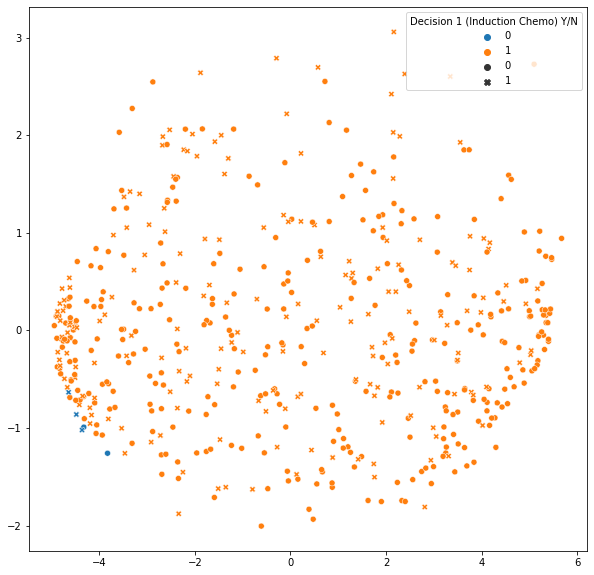

In [48]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def plot_embedding(dataset,dmodel,decision=0,ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(10,10))
    embeddings, decisions_optimal, decisions_imitation = get_embeddings(dataset,dmodel,states=[decision])
    pca = PCA(2)
    coords = pca.fit_transform(embeddings[0])
    marks = data.get_state('decision'+ str(decision+1))
#     predicted = (decisions_optimal > .25).ravel().astype(int)
    predicted = (decisions_imitation > .5).ravel().astype(int)
    sns.scatterplot(data=coords,
                    x=coords[:,0],
                    y=coords[:,1],
                    style=marks,
                    hue=predicted,
                    ax=ax,
                   )
plot_embedding(data,decision_model)

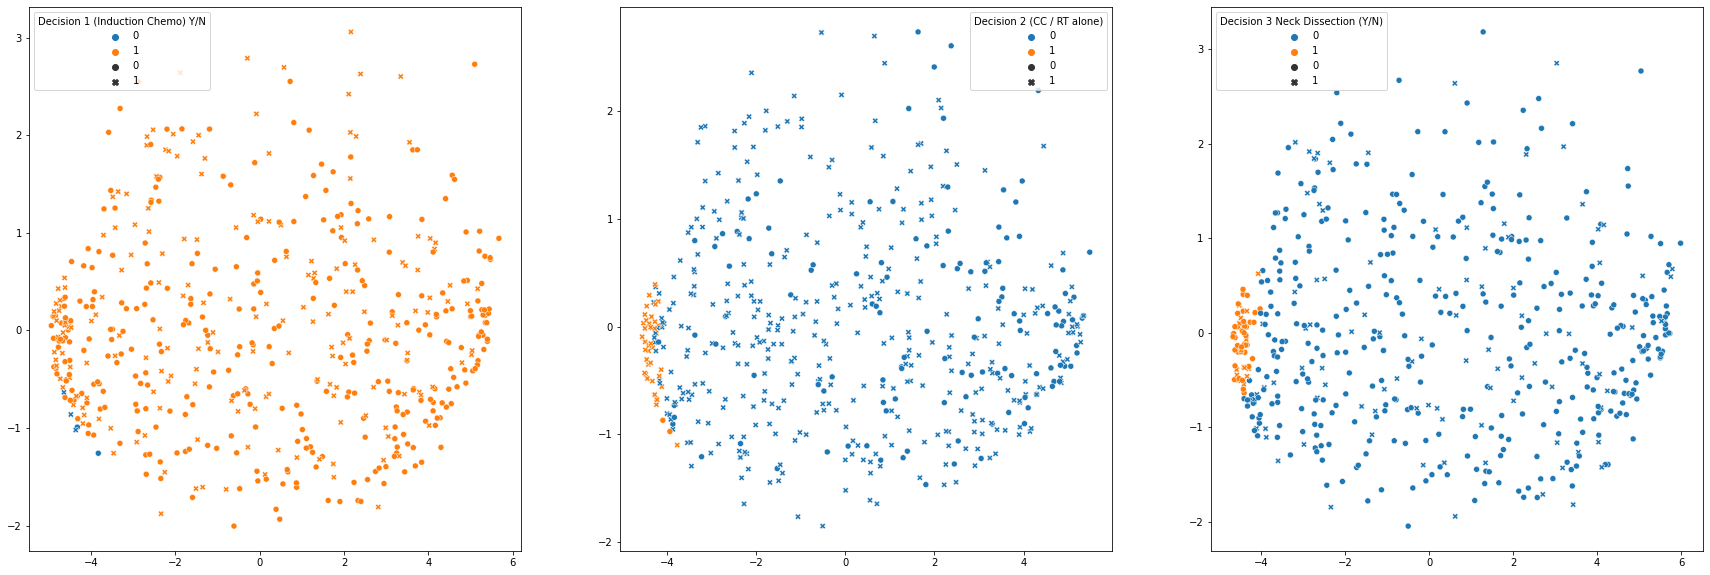

In [49]:
fig,axes = plt.subplots(1,3,figsize=(30,10))
for i in range(3):
    plot_embedding(data,decision_model,decision=i,ax=axes[i])

In [ ]:
def get_default_input(dataset,state=0,ids=None):
    output = get_decision_input(dataset,state=state,ids=ids)
    output = [o.median().to_dict() for o in output]
    return output

get_default_input(data)

In [ ]:
def format_patient(dataset,input_dict):
    #converts patient input features into data input type
    baselines = dataset.processed_df.median().to_dict()
    for k,v in input_dict.items():
        baselines[k] = v
    return baselines

format_patient(data,{'ln_cluster_3': 1,'DLT_Neurological': 1})

In [ ]:
def dict_to_model_input(dataset,fdict,state=1):
    #state goes from 1-3 because I wrote it for training models instead of the input, but position for model should be 0-2 (state - 1)
    fdict = format_patient(dataset,fdict)
    order = get_inputkey_order(dataset,state=state)
    inputs = [torch.tensor([fdict[k] for k in ordersubset]).type(torch.FloatTensor).view(1,-1) for ordersubset in order]
    #this is assuming the order is baseline, dlt1, dlt2, primary progression, nodal progression, cc type, dose modification
    def zeroinput(position):
        return torch.zeros(inputs[position].shape).type(torch.FloatTensor)
    if state == 0 or state == 1:
        inputs[2] = zeroinput(2)
        inputs[5] = zeroinput(5)
    if state < 1:
        inputs[1] = zeroinput(1)
        inputs[3] = zeroinput(3)
        inputs[4] = zeroinput(4)
        inputs[6] =zeroinput(6)
        
    return inputs
# decision_model(*dict_to_model_input(data,data.processed_df.iloc[7].to_dict(),state=0),position=0)
dict_to_model_input(data,data.processed_df.iloc[7].to_dict(),state=1)

In [ ]:
def get_stuff_for_patient(patient_dict,data):